<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/GDSTK_Meandering_Curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdstk hilbertcurve

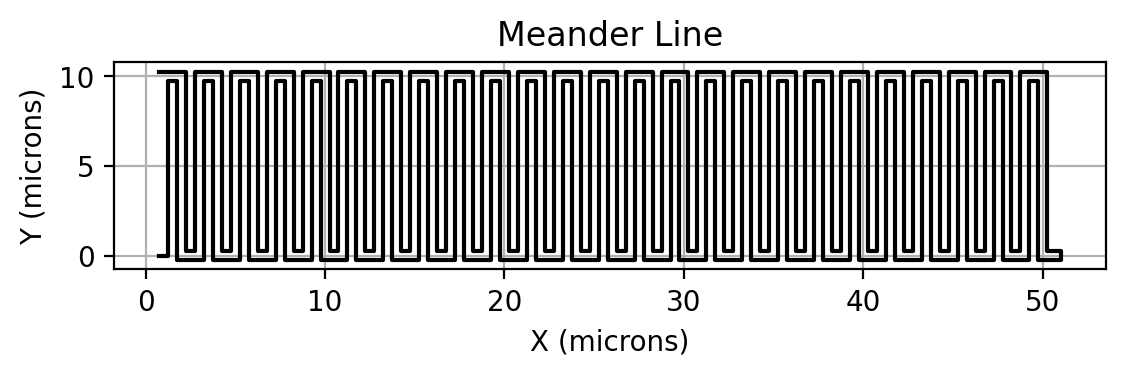

In [26]:
# Basic meandering line (to show progression)
# Author: Onri Jay Benally

import gdstk
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["figure.dpi"] = 200  # crisp preview

# Parameters
iterations = 50
line_width = 0.5  # in microns
segment_length = 1.0  # length of horizontal segments
segment_height = 10.0   # height of vertical segments

# Initialize starting point
points = []
x, y = 0.0, 0.0
direction = 1  # 1 for up, -1 for down

for i in range(iterations):
    # Horizontal segment
    x += segment_length
    points.append((x, y))
    # Vertical segment
    y += direction * segment_height
    points.append((x, y))
    # Reverse direction
    direction *= -1

# Final horizontal segment to complete the pattern
x += segment_length
points.append((x, y))

# Create FlexPath
path = gdstk.FlexPath(points, line_width)

# Create cell and library
cell = gdstk.Cell("MEANDER_LINE")
cell.add(path)
lib = gdstk.Library()
lib.add(cell)

# Write to GDSII file
lib.write_gds("wide_meander_line.gds")

# Plot using matplotlib
fig, ax = plt.subplots()
for polygon in path.to_polygons():
    x_coords, y_coords = zip(*polygon.points)
    ax.plot(x_coords, y_coords, 'k-')
ax.set_aspect('equal')
plt.title("Meander Line")
plt.xlabel("X (microns)")
plt.ylabel("Y (microns)")
plt.grid(True)
plt.show()

In [27]:
from google.colab import files
files.download("wide_meander_line.gds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

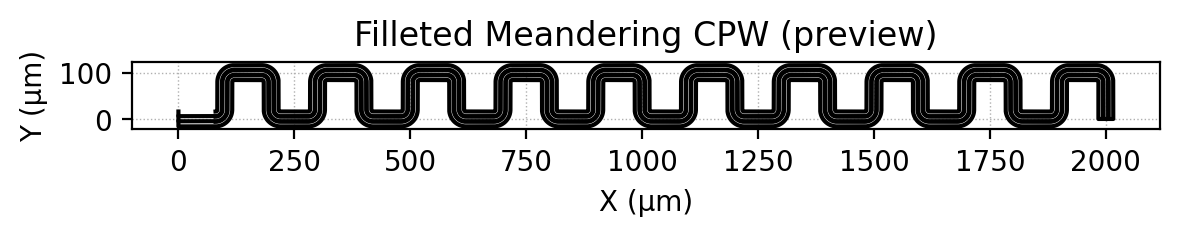

In [28]:
# Meandering CPW with filleted elbows (fab‑ready)
# Author: Onri Jay Benally
# ------------------------------------------------
# This script rewrites the original sharp‑corner CPW meander using
# gdstk.FlexPath with a user‑defined bend radius.  All 90° elbows are
# automatically replaced with circular arcs, giving a clean, lithography‑
# friendly layout.  The left/right gap outlines are generated by offsetting
# the same spine, so they inherit identical curvature and spacing.

import gdstk
import numpy as np
import matplotlib.pyplot as plt

# -------------------- User‑tunable parameters --------------------
total_length = 2000.0   # µm  – overall X span of the meander
center_width = 10.0     # µm  – signal line width
cpw_gap      = 6.0      # µm  – gap between signal and ground edge
segment      = 100.0    # µm  – horizontal step size per fold
bend_radius  = 20.0     # µm  – inner radius of every elbow (must be < segment/2)
layer_sig    = 1        # GDS layer for signal line
layer_gap    = 2        # GDS layer marking the gap edge (etch/keep‑out)

# -------------------- Derived quantities -------------------------
num_segments = int(total_length / segment)

# -------------------- Build the meander spine --------------------
spine = [(0.0, 0.0)]

x, y = 0.0, 0.0
sign = 1  # +1 for up, ‑1 for down
for _ in range(num_segments):
    x += segment
    spine.append((x, y))
    y += sign * segment
    spine.append((x, y))
    sign *= -1  # flip direction for next vertical step

# -------------------- Create FlexPaths with circular bends --------
#   bend_radius automatically inserts a quarter‑circle arc at each turn.
center_fp = gdstk.FlexPath(
    spine,
    center_width,
    bend_radius=bend_radius,
    simple_path=True,
    layer=layer_sig,
)

# Offset copies for the CPW gaps
l_offset = center_width / 2 + cpw_gap

left_gap_fp = gdstk.FlexPath(
    spine,
    center_width,
    offset=l_offset,
    bend_radius=bend_radius,
    simple_path=True,
    layer=layer_gap,
)
right_gap_fp = gdstk.FlexPath(
    spine,
    center_width,
    offset=-l_offset,
    bend_radius=bend_radius,
    simple_path=True,
    layer=layer_gap,
)

# -------------------- Assemble GDS -------------------------------
cell = gdstk.Cell("MEANDERING_CPW_FILLET")
cell.add(center_fp, left_gap_fp, right_gap_fp)

lib = gdstk.Library()
lib.add(cell)
lib.write_gds("meandering_cpw_fillet.gds")

# -------------------- Quick matplotlib preview -------------------
fig, ax = plt.subplots(figsize=(6, 6))
for fp in (center_fp, left_gap_fp, right_gap_fp):
    for poly in fp.to_polygons():
        x_pts, y_pts = zip(*poly.points)
        ax.plot(x_pts, y_pts, "k-")

ax.set_aspect("equal")
ax.set_title("Filleted Meandering CPW (preview)")
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.grid(True, ls=":", lw=0.5)
plt.tight_layout()
plt.show()

# -------------------- Notes --------------------------------------
# • The chosen bend_radius (20 µm) keeps the circular arcs fully within
#   each 100 µm segment.  Increase it cautiously if you lengthen segments.
# • The gap outlines are placed on a separate layer so you can drive the
#   etch/metal fill rules downstream.  Adjust `layer_gap` as needed.
# • For foundry‑specific design rules, ensure that:
#     ‑ bend_radius ≥ minimum bend spec (avoids current crowding);
#     ‑ center_width ≥ minimum line width;
#     ‑ cpw_gap     ≥ minimum spacing.
# • To add ground shapes, ground return vias, or taper transitions, insert
#   additional geometry before writing the GDS.

In [29]:
from google.colab import files
files.download("meandering_cpw_fillet.gds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

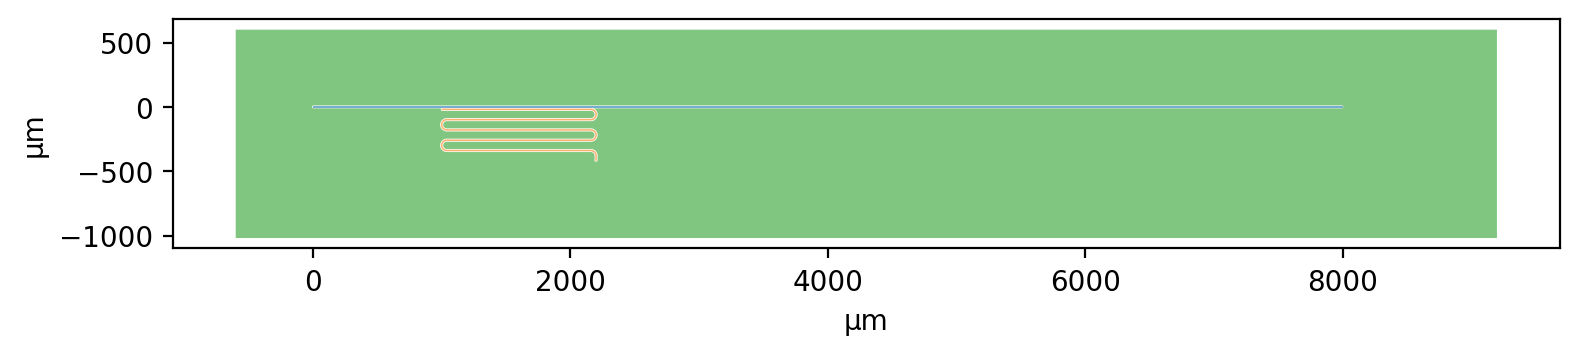

Wrote cpw_meander_v3.gds to current directory.


In [31]:
# Adapted CPW Meander Layout — Feed ▸ λ/4-Resonator ▸ (Optional) Qubit
#
# Inspired by Onri J. Benally's CPW notebooks (v1, v2).
# This single-file script parameterises the entire layout via a
# `tech` dictionary and produces a GDS with smooth-fillet meanders,
# a feed line, and an automatically carved ground plane.
# -------------------------------------------------------------
# Author : ChatGPT (o3)
# Date   : 2025-06-04
# -------------------------------------------------------------
# Usage (local or Colab):
#   1. pip install gdstk matplotlib
#   2. python cpw_meander_adapted.py  # writes cpw_meander_v3.gds
# -------------------------------------------------------------

import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200  # crisp preview

# -------------------------------------------------------------
# 1) Technology / Geometry Parameters
# -------------------------------------------------------------
tech = dict(
    # ---- Feedline ----
    w_feed   = 10.0,   # µm  signal width
    g_feed   = 6.0,    # µm  gap to ground
    feed_len = 8000.0,  # µm  horizontal span of feed

    # ---- λ/4 CPW resonator ----
    lambda_quarter = 6000.0,  # µm electrical length ≈ λ_g/4
    n_meanders     = 5,       # folds in the serpentine
    w_res          = 12.0,    # µm  signal width (resonator)
    g_res          = 6.0,     # µm  gap around resonator
    fillet         = 40.0,    # µm  bend radius for FlexPath

    # ---- Placement offsets ----
    d_feed_res = 2.0,  # µm vertical gap feed ↔ resonator edge

    # ---- Ground-plane & chip framing ----
    margin   = 600.0,  # µm extra chip border
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # for keep-out calc

# -------------------------------------------------------------
# 2) Helper Functions
# -------------------------------------------------------------

def preview(cell, figsize=(7, 4)):
    """Lightweight matplotlib plot (works without gdstk.Cell.plot)."""
    fig, ax = plt.subplots(figsize=figsize)
    for poly in cell.polygons:
        pts = poly.points
        ax.fill(*zip(*pts), lw=0.3, alpha=0.6)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    w      = width
    return [gdstk.rectangle((x0, y0 - w / 2), (x0 + length, y0 + w / 2))]


def build_meander(origin, p):
    """Return polygons for a smooth-fillet λ/4 meander and its exit anchor."""
    x0, y0   = origin
    seg      = p["lambda_quarter"] / p["n_meanders"]
    w        = p["w_res"]
    r        = p["fillet"]

    pts      = [(x0, y0)]
    cx, cy   = x0, y0
    direction = 1  # +1 → right, −1 → left horizontal advance
    for _ in range(p["n_meanders"]):
        cx += direction * seg
        pts.append((cx, cy))          # horizontal
        cy -= 2 * r
        pts.append((cx, cy))          # vertical drop (2×r to fit fillet)
        direction *= -1

    path = gdstk.FlexPath(
        pts,
        w,
        bend_radius=r,
        simple_path=True,
    )
    return path.to_polygons(), (cx, cy)

# -------------------------------------------------------------
# 3) Chip Assembly
# -------------------------------------------------------------

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)  # unit = 1 µm
    cell = lib.new_cell("MAIN")

    conductors = []  # to union for keep-out later

    # -- Feedline (top, centred at y=0) --
    feed = build_straight_cpw((0.0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(*feed)
    conductors.extend(feed)

    # -- Meander resonator (below feed) --
    res_origin = (
        1000.0,  # 1 mm offset in x for easy probing space
        -(p["w_feed"]/2 + p["g_feed"] + p["d_feed_res"] + p["w_res"]/2),
    )
    meander_polys, (end_x, end_y) = build_meander(res_origin, p)
    cell.add(*meander_polys)
    conductors.extend(meander_polys)

    # -- Add more structures (e.g. qubit pads) here if desired --

    # -- Ground plane carving --
    conductor_union = gdstk.boolean(conductors, [], "or")
    clearance       = p["g_max"] + 0.1  # µm
    keepout         = gdstk.offset(conductor_union, clearance, join="round")

    chip_w = p["feed_len"] + 2 * p["margin"]
    chip_h_pos = p["margin"]
    chip_h_neg = abs(end_y) + p["margin"]
    full_ground = gdstk.rectangle((-p["margin"], -chip_h_neg), (chip_w, chip_h_pos))

    ground = gdstk.boolean(full_ground, keepout, "not")
    cell.add(*ground)

    return lib

# -------------------------------------------------------------
# 4) Preview & GDS Export
# -------------------------------------------------------------
if __name__ == "__main__":
    lib = build_full_chip(tech)
    main = lib.top_level()[0]
    preview(main, figsize=(8, 4))

    gds_fname = "cpw_meander_v3.gds"
    lib.write_gds(gds_fname)
    print(f"Wrote {gds_fname} to current directory.")

In [32]:
from google.colab import files
files.download("cpw_meander_v3.gds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

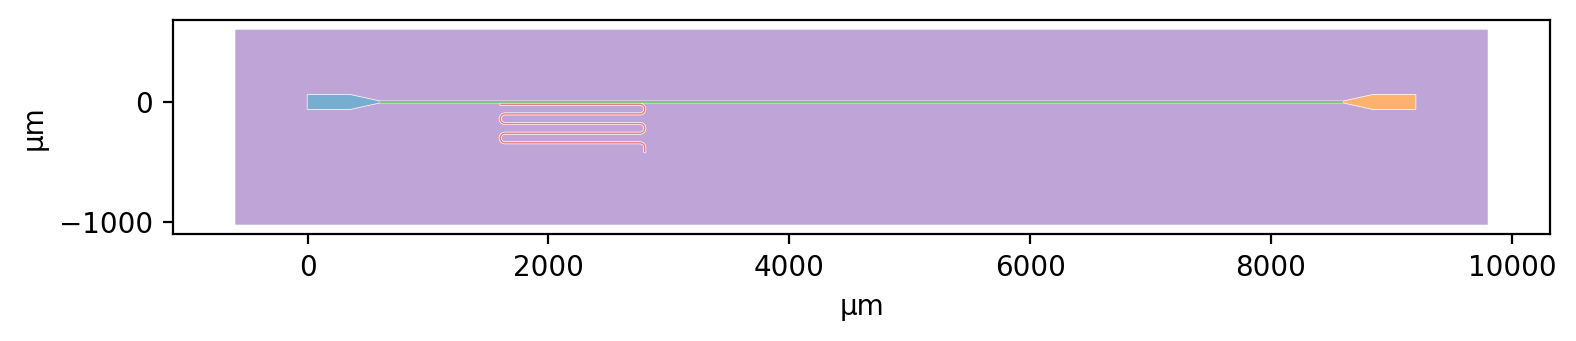

Wrote cpw_meander_with_pads.gds to current directory.


In [34]:
# Adapted CPW Meander Layout — Feed ▸ λ/4-Resonator ▸ (Optional) Qubit
#
# Inspired by Onri J. Benally's CPW notebooks (v1, v2).
# This single‑file script parameterises the entire layout via a
# `tech` dictionary, produces tapered launch pads on both ends,
# a feed line, a smooth‑fillet λ/4 resonator, and an automatically
# carved ground plane.
# -------------------------------------------------------------
# Author : ChatGPT (o3)
# Date   : 2025‑06‑04  (launch‑pad attachment revision)
# -------------------------------------------------------------
# Usage (local or Colab):
#   1. pip install gdstk matplotlib
#   2. python cpw_meander_with_pads.py  # writes cpw_meander_with_pads.gds
# -------------------------------------------------------------

import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200  # crisp preview

# -------------------------------------------------------------
# 1) Technology / Geometry Parameters
# -------------------------------------------------------------
tech = dict(
    # ---- Feedline ----
    w_feed   = 10.0,      # µm  signal width
    g_feed   = 6.0,       # µm  gap to ground
    feed_len = 8000.0,    # µm  horizontal span of feed (between tapers)

    # ---- Launch‑pad / taper ----
    w_pad         = 120.0,   # µm  pad width (signal)
    pad_len       = 350.0,   # µm  pad length (rectangular section)
    pad_taper_len = 250.0,   # µm  linear taper length from w_feed → w_pad

    # ---- λ/4 CPW resonator ----
    lambda_quarter = 6000.0,  # µm electrical length ≈ λ_g/4
    n_meanders     = 5,       # folds in the serpentine
    w_res          = 12.0,    # µm  signal width
    g_res          = 6.0,     # µm  gap around resonator
    fillet         = 40.0,    # µm  bend radius for FlexPath

    # ---- Placement offsets ----
    d_feed_res = 2.0,         # µm vertical gap feed ↔ resonator edge

    # ---- Ground‑plane & chip framing ----
    margin   = 600.0,         # µm extra chip border
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # for keep‑out calc

# -------------------------------------------------------------
# 2) Helper Functions
# -------------------------------------------------------------

def preview(cell, figsize=(7, 4)):
    """Lightweight matplotlib plot (works without gdstk.Cell.plot)."""
    fig, ax = plt.subplots(figsize=figsize)
    for poly in cell.polygons:
        ax.fill(*zip(*poly.points), lw=0.25, alpha=0.6)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [gdstk.rectangle((x0, y0 - width / 2), (x0 + length, y0 + width / 2))]


def build_launch_pad(origin_x, y0, direction, p):
    """Return a polygon comprising a linear taper and a rectangular pad.

    Parameters
    ----------
    origin_x : float
        x‑coordinate where the taper attaches to the narrow feed.
    y0 : float
        Centre y‑coordinate of the CPW signal.
    direction : int
        +1 → pad extends to +x; −1 → pad extends to −x.
    """
    w1, w2 = p["w_feed"], p["w_pad"]
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]

    x_feed      = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end   = x_taper_end + direction * pad_len

    pts = [
        (x_feed,      y0 + w1/2),
        (x_taper_end, y0 + w2/2),
        (x_pad_end,   y0 + w2/2),
        (x_pad_end,   y0 - w2/2),
        (x_taper_end, y0 - w2/2),
        (x_feed,      y0 - w1/2),
    ]
    return gdstk.Polygon(pts)


def build_meander(origin, p):
    x0, y0 = origin
    seg    = p["lambda_quarter"] / p["n_meanders"]
    w      = p["w_res"]
    r      = p["fillet"]

    pts, cx, cy, direction = [(x0, y0)], x0, y0, 1
    for _ in range(p["n_meanders"]):
        cx += direction * seg
        pts.append((cx, cy))
        cy -= 2 * r
        pts.append((cx, cy))
        direction *= -1

    path = gdstk.FlexPath(pts, w, bend_radius=r, simple_path=True)
    return path.to_polygons(), (cx, cy)

# -------------------------------------------------------------
# 3) Chip Assembly
# -------------------------------------------------------------

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)  # unit = 1 µm
    cell = lib.new_cell("MAIN")
    conductors = []

    # Common anchor where both tapers meet the feed line
    feed_origin_x = p["pad_len"] + p["pad_taper_len"]

    # -- Launch pads & feed line (centre y = 0) --
    pad_left = build_launch_pad(
        origin_x=feed_origin_x,  # attaches flush to feed
        y0=0.0,
        direction=-1,
        p=p,
    )
    pad_right = build_launch_pad(
        origin_x=feed_origin_x + p["feed_len"],
        y0=0.0,
        direction=+1,
        p=p,
    )
    feed = build_straight_cpw(
        (feed_origin_x, 0.0),
        p["feed_len"],
        p["w_feed"],
    )

    cell.add(pad_left, pad_right, *feed)
    conductors.extend([pad_left, pad_right, *feed])

    # -- Meander resonator (below feed) --
    res_origin = (
        feed_origin_x + 1000.0,  # 1 mm from left taper root
        -(p["w_feed"]/2 + p["g_feed"] + p["d_feed_res"] + p["w_res"]/2),
    )
    meander_polys, (end_x, end_y) = build_meander(res_origin, p)
    cell.add(*meander_polys)
    conductors.extend(meander_polys)

    # -- Ground plane carving --
    conductor_union = gdstk.boolean(conductors, [], "or")
    clearance       = p["g_max"] + 0.1
    keepout         = gdstk.offset(conductor_union, clearance, join="round")

    chip_w = (
        p["feed_len"] + 2 * (p["pad_len"] + p["pad_taper_len"]) + 2 * p["margin"]
    )
    chip_h_pos = p["margin"]
    chip_h_neg = abs(end_y) + p["margin"]
    full_ground = gdstk.rectangle(
        (-p["margin"], -chip_h_neg),
        (chip_w - p["margin"], chip_h_pos),
    )

    ground = gdstk.boolean(full_ground, keepout, "not")
    cell.add(*ground)
    return lib

# -------------------------------------------------------------
# 4) Preview & GDS Export
# -------------------------------------------------------------
if __name__ == "__main__":
    lib  = build_full_chip(tech)
    main = lib.top_level()[0]
    preview(main, figsize=(8, 4))

    gds_fname = "cpw_meander_with_pads.gds"
    lib.write_gds(gds_fname)
    print(f"Wrote {gds_fname} to current directory.")

In [35]:
from google.colab import files
files.download("cpw_meander_with_pads.gds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

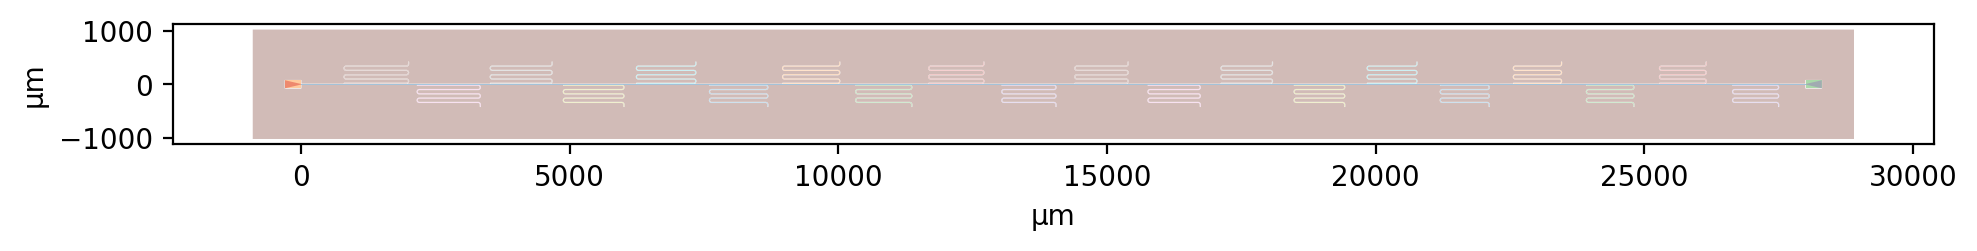

GDS saved as cpw_20_meanders.gds in current directory.


In [ ]:
# =============================================================
# Compact CPW Feed with 20 Staggered λ/4 Resonator Meanders
# =============================================================
# Upgrades over previous octet version:
#   • Twenty (20) resonators, alternating above/below the feed.
#   • Feed-line launch pads now include linear tapers that widen
#     smoothly from the feed width to the full pad width.
# -------------------------------------------------------------
# Author : Onri Jay Benally
# Date   : 2025-06-04
# -------------------------------------------------------------
# How to run (local or Colab):
#   pip install gdstk matplotlib
#   python cpw_20_meanders.py
#   → writes cpw_20_meanders.gds and pops a preview window.
# -------------------------------------------------------------

import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200

# -------------------------------------------------------------
# 1) Technology & Layout Parameters
# -------------------------------------------------------------
tech = dict(
    # Central feed
    w_feed   = 10.0,    # µm  signal width
    g_feed   = 6.0,     # µm  gap to ground
    feed_len = 28000.0, # µm  (≈ 28 mm) – room for 20 resonators + pads

    # Resonators
    w_res    = 10.0,    # µm signal width
    g_res    = 6.0,     # µm gap
    n_meanders = 5,      # folds per resonator
    fillet      = 40.0,  # µm bend radius
    d_feed_res  = 2.0,   # µm vertical spacing feed ↔ resonator (edge-edge)

    # Launch pads (with taper)
    pad_len = 300.0,   # µm length along feed axis
    pad_wid = 150.0,   # µm width across feed

    # Chip frame margin
    margin   = 600.0,  # µm border
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # keep-out clearance

# Quarter-wave reference length: 5 GHz ↔ 6000 µm (empirical)
LQ_5GHz = 6000.0

# 20 design frequencies 5 → 7 GHz
freqs = np.linspace(5.0, 7.0, 20)  # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs  # L ∝ 1/f

# -------------------------------------------------------------
# 2) Helper utils
# -------------------------------------------------------------

def preview(cell, figsize=(10, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    cell.plot(ax) if hasattr(cell, "plot") else [ax.fill(*zip(*poly.points), alpha=0.4) for poly in cell.polygons]
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()


def rect(x0, y0, x1, y1):
    """Convenience wrapper – returns a gdstk polygon rectangle."""
    return gdstk.rectangle((x0, y0), (x1, y1))


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]


def build_taper(left_x, right_x, y_c, w_left, w_right):
    """Linear taper polygon from width w_left at left_x → w_right at right_x."""
    half_l = w_left / 2
    half_r = w_right / 2
    pts = [
        (left_x,  y_c - half_l),
        (left_x,  y_c + half_l),
        (right_x, y_c + half_r),
        (right_x, y_c - half_r),
    ]
    return [gdstk.Polygon(pts)]


def build_meander(origin, lambda_quarter, p, upward=True):
    x0, y0   = origin
    seg      = lambda_quarter / p["n_meanders"]
    w        = p["w_res"]
    r        = p["fillet"]
    pts      = [(x0, y0)]
    cx, cy   = x0, y0
    direction = 1
    sign_v    = 1 if upward else -1

    for _ in range(p["n_meanders"]):
        cx += direction * seg
        pts.append((cx, cy))
        cy += sign_v * 2 * r
        pts.append((cx, cy))
        direction *= -1

    path = gdstk.FlexPath(pts, w, bend_radius=r, simple_path=True)
    return path.to_polygons()

# -------------------------------------------------------------
# 3) Chip assembly
# -------------------------------------------------------------

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")

    polys = []  # all conductor shapes

    # --- Feed line ---
    feed = build_straight_cpw((0.0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(*feed)
    polys.extend(feed)

    # --- Launch pads + linear tapers ---
    pad_y = 0.0
    # Left side: pad spans x ∈ [-pad_len, 0]
    left_pad  = rect(-p["pad_len"], pad_y - p["pad_wid"]/2, 0.0, pad_y + p["pad_wid"]/2)
    left_taper = build_taper(0.0, -p["pad_len"], pad_y, p["w_feed"], p["pad_wid"])[0]

    # Right side: pad spans x ∈ [feed_len, feed_len + pad_len]
    right_pad = rect(p["feed_len"], pad_y - p["pad_wid"]/2, p["feed_len"] + p["pad_len"], pad_y + p["pad_wid"]/2)
    right_taper = build_taper(p["feed_len"], p["feed_len"] + p["pad_len"], pad_y, p["w_feed"], p["pad_wid"])[0]

    cell.add(left_pad, right_pad, left_taper, right_taper)
    polys.extend([left_pad, right_pad, left_taper, right_taper])

    # --- Resonators ---
    seg_max = max(lambda_quarters) / p["n_meanders"]
    pitch   = seg_max + 4 * p["fillet"]
    start_x = p["pad_len"] + 500.0  # 500 µm gap from taper end

    y_off = p["w_feed"]/2 + p["g_feed"] + p["d_feed_res"] + p["w_res"]/2

    for idx, (fq, lq) in enumerate(zip(freqs, lambda_quarters)):
        upward = idx % 2 == 0
        x_anchor = start_x + idx * pitch
        y_anchor = y_off if upward else -y_off
        origin = (x_anchor, y_anchor)
        res_polys = build_meander(origin, lq, p, upward=upward)
        cell.add(*res_polys)
        polys.extend(res_polys)

    # --- Ground plane ---
    conductor_union = gdstk.boolean(polys, [], "or")
    clearance = p["g_max"] + 0.1
    keepout = gdstk.offset(conductor_union, clearance, join="round")

    xs = np.concatenate([poly.points[:, 0] for poly in polys])
    ys = np.concatenate([poly.points[:, 1] for poly in polys])
    min_x, max_x = xs.min(), xs.max()
    min_y, max_y = ys.min(), ys.max()

    frame = rect(min_x - p["margin"], min_y - p["margin"], max_x + p["margin"], max_y + p["margin"])
    ground = gdstk.boolean(frame, keepout, "not")
    cell.add(*ground)

    return lib

# -------------------------------------------------------------
# 4) Run & export
# -------------------------------------------------------------
if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top)

    out_name = "cpw_20_meanders.gds"
    lib.write_gds(out_name)
    print(f"GDS saved as {out_name} in current directory.")

In [ ]:
from google.colab import files
files.download("cpw_20_meanders.gds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

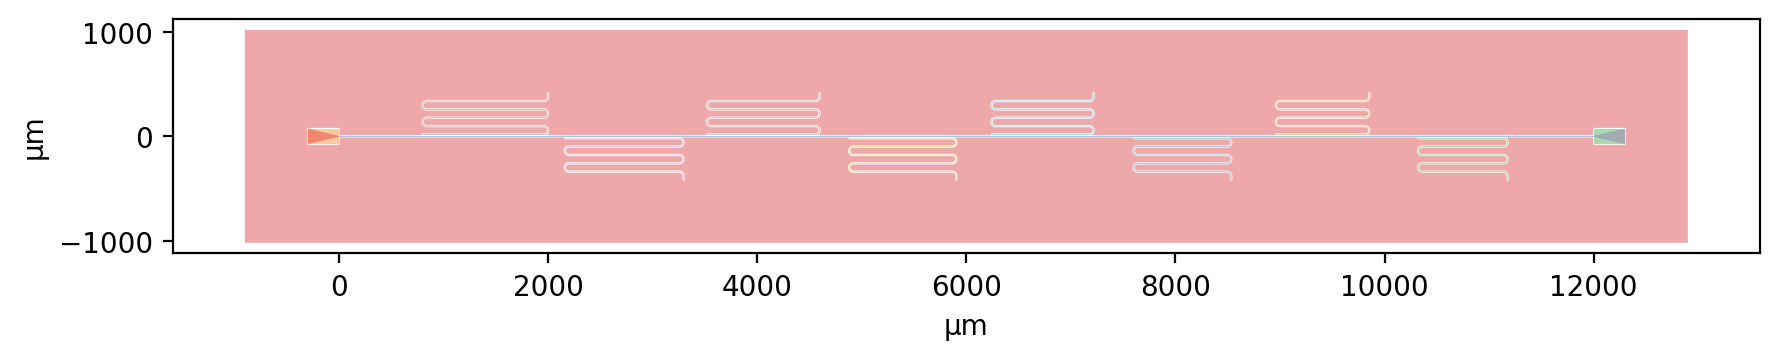

GDS written to cpw_8_meanders_12mm.gds


In [ ]:
# =============================================================
# CPW Feed (12 000 µm) with 8 Staggered λ/4 Resonator Meanders
# =============================================================
#   • Central coplanar-waveguide (CPW) feed length: 12 000 µm.
#   • Eight resonators with fundamental frequencies spanning
#     5 GHz → 7 GHz, alternating above / below the feed line.
#   • Launch pads at both ends taper linearly from 10 µm feed width
#     to 150 µm pad width.
# -------------------------------------------------------------
# Author : Onri Jay Benally
# Date   : 2025-06-04
# -------------------------------------------------------------
# Run locally or in Colab:
#   pip install gdstk matplotlib
#   python cpw_8_meanders_12mm.py
# -------------------------------------------------------------

import gdstk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 200

# -------------------------------------------------------------
# 1) Technology & Layout Parameters
# -------------------------------------------------------------
tech = dict(
    # Feed line
    w_feed   = 10.0,     # µm  signal width
    g_feed   = 6.0,      # µm  gap to ground
    feed_len = 12_000.0, # µm  (12 mm)

    # Resonators
    w_res      = 10.0,   # µm  signal width
    g_res      = 6.0,    # µm  gap
    n_meanders = 5,      # folds per resonator
    fillet     = 40.0,   # µm  bend radius
    d_feed_res = 2.0,    # µm  vertical spacing feed ↔ resonator edge

    # Launch pads (+ linear taper)
    pad_len = 300.0,   # µm along feed axis
    pad_wid = 150.0,   # µm transverse width

    # Chip margin
    margin  = 600.0,   # µm around conductors
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # keep-out clearance

# Quarter-wave reference length at 5 GHz (empirical)
LQ_5GHz = 6000.0  # µm ≈ λ_g/4 @ 5 GHz

# 8 design frequencies (5 → 7 GHz)
freqs = np.linspace(5.0, 7.0, 8)  # GHz
lambda_quarters = LQ_5GHz * 5.0 / freqs  # simple f⁻¹ scaling

# -------------------------------------------------------------
# 2) Helper Functions
# -------------------------------------------------------------

def preview(cell, figsize=(9, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    if hasattr(cell, "plot"):
        cell.plot(ax)
    else:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), alpha=0.4, lw=0.3)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()


def rect(x0, y0, x1, y1):
    return gdstk.rectangle((x0, y0), (x1, y1))


def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [rect(x0, y0 - width/2, x0 + length, y0 + width/2)]


def build_taper(x_left, x_right, y_c, w_left, w_right):
    half_l, half_r = w_left/2, w_right/2
    pts = [
        (x_left,  y_c - half_l),
        (x_left,  y_c + half_l),
        (x_right, y_c + half_r),
        (x_right, y_c - half_r),
    ]
    return [gdstk.Polygon(pts)]


def build_meander(origin, lambda_q, p, upward=True):
    x0, y0   = origin
    seg      = lambda_q / p["n_meanders"]
    w        = p["w_res"]
    r        = p["fillet"]

    cx, cy = x0, y0
    pts = [(cx, cy)]
    dir_h  = 1  # horizontal advance direction (+x / -x)
    sign_v = 1 if upward else -1

    for _ in range(p["n_meanders"]):
        cx += dir_h * seg
        pts.append((cx, cy))
        cy += sign_v * 2 * r
        pts.append((cx, cy))
        dir_h *= -1

    fp = gdstk.FlexPath(pts, w, bend_radius=r, simple_path=True)
    return fp.to_polygons()

# -------------------------------------------------------------
# 3) Chip Assembly
# -------------------------------------------------------------

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")

    conductors = []  # for keep-out later

    # Feed line
    feed = build_straight_cpw((0.0, 0.0), p["feed_len"], p["w_feed"])
    cell.add(*feed)
    conductors.extend(feed)

    # Launch pads + tapers
    pad_y = 0.0
    L, W, wf = p["pad_len"], p["pad_wid"], p["w_feed"]

    left_pad   = rect(-L, pad_y - W/2, 0.0, pad_y + W/2)
    right_pad  = rect(p["feed_len"], pad_y - W/2, p["feed_len"] + L, pad_y + W/2)
    left_taper = build_taper(0.0, -L, pad_y, wf, W)[0]
    right_taper= build_taper(p["feed_len"], p["feed_len"] + L, pad_y, wf, W)[0]

    cell.add(left_pad, right_pad, left_taper, right_taper)
    conductors.extend([left_pad, right_pad, left_taper, right_taper])

    # Resonators
    seg_max = max(lambda_quarters) / p["n_meanders"]
    pitch   = seg_max + 4 * p["fillet"]
    start_x = p["pad_len"] + 500.0  # gap from taper end

    y_off   = p["w_feed"]/2 + p["g_feed"] + p["d_feed_res"] + p["w_res"]/2

    for idx, (fq, lq) in enumerate(zip(freqs, lambda_quarters)):
        upward = idx % 2 == 0
        x_anchor = start_x + idx * pitch
        y_anchor = y_off if upward else -y_off
        pols = build_meander((x_anchor, y_anchor), lq, p, upward=upward)
        cell.add(*pols)
        conductors.extend(pols)

    # Ground plane carve
    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")

    xs = np.concatenate([poly.points[:,0] for poly in conductors])
    ys = np.concatenate([poly.points[:,1] for poly in conductors])
    min_x, max_x = xs.min(), xs.max()
    min_y, max_y = ys.min(), ys.max()

    frame = rect(min_x - p["margin"], min_y - p["margin"], max_x + p["margin"], max_y + p["margin"])
    ground = gdstk.boolean(frame, keepout, "not")
    cell.add(*ground)

    return lib

# -------------------------------------------------------------
# 4) Main
# -------------------------------------------------------------
if __name__ == "__main__":
    lib = build_full_chip(tech)
    top = lib.top_level()[0]
    preview(top)

    out_file = "cpw_8_meanders_12mm.gds"
    lib.write_gds(out_file)
    print(f"GDS written to {out_file}")

In [ ]:
from google.colab import files
files.download("cpw_8_meanders_12mm.gds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>